In [834]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

---
### Helper Functions

In [616]:
def getSeriesDF(cid, filename):
    localDF = pd.read_csv('data/Chunks/'+fileName+".csv").drop(columns=['Unnamed: 0'])
    localDF = localDF.loc[localDF['ContestId']==cid]
    localDF = localDF.assign(InvertedTime = localDF['SecondsRemaining'].max()-localDF['SecondsRemaining'])
    localDF = localDF.assign(SummedEntries = localDF['Entries'][::-1].cumsum()[::-1])
    return localDF
def zipCols(col1, col2):
    combined = []
    col1 = list(col1)
    col2 = list(col2)
    for i in range(0, len(col1)):
        combined.append([(col1[i]), col2[i]])
    return combined[::-1]
def combineStatesAndObservations(time, observations, states):
    combined = [[0, 0]]*max(time)
    stateSum = 0
    for i in range(0, len(combined)):
        if(i in list(time)):
            index = list(time).index(i)
#             print(index)

            stateSum = states.iloc[index]
            combined[i] = [observations.iloc[index], states.iloc[index]]
        else:
            combined[i] = [0, stateSum]
    return combined

chunkMapDF = pd.read_csv('data/chunkMap.csv')
def getRandomContestAndLocation():
    contest = chunkMapDF.sample(n=1).iloc[0]
    cid, fileName  = contest.ContestId, contest.Chunk
    return cid, fileName

def modelValues(A, B, Times):
    y = []
    for i in Times:
        val = A*math.exp(B*i)
        y.append(val)
    return y

def get100Models(Xs, Times, extended=False):
    results = []
    dif = 1   
    if len(Xs)> 100:
        dif = int(len(Xs)/100.)             
    for i in range(0, len(Xs), dif):
        Xk = Xs[i].tolist()
        if(extended):
            results.append(modelValues(Xk[0][0], Xk[1][0], Times))
        else:
            results.append(np.exp(modelValues(Xk[0][0]), Xk[1][0], Times))
    return results
def getKindaBigContest():
    cid, fileName = getRandomContestAndLocation()
#     print(cid, fileName)
    fullSeriesDF = getSeriesDF(cid, fileName)
    length = len(fullSeriesDF)
    if length < 10:
        return getKindaBigContest()
    else:
        return fullSeriesDF

def getQ():
    Q_sub = random_state.randn(2, 2)
    Q = np.dot(Q_sub, Q_sub.transpose())
    val = np.linalg.matrix_rank(Q)
    print(val)
    if(val == 2):
        return Q
    else:
        return getQ()

---
### Kalman Functions

In [591]:
#NOTE! This is the predicted number of entrants based on the current timesetp
def kalmanPredictNextVal(tCurr, xCurr, extended=False):
    if(extended):
        part1 = np.exp(xCurr[1][0]*tCurr)
        Hk = [part1, part1*(xCurr[0][0]*tCurr)]
        Zk = xCurr[0][0]*np.exp(xCurr[1][0]*tCurr)
#         print("do something")
        return Hk,  Zk
    else:
        Hk = [1., tCurr]
        Zk = np.dot(Hk, xCurr) + np.random.normal(loc=0., scale=R) #<----- Consider putting Vk instead of R
        return Hk,  Zk

        # kalmanPredictNextVal(kalmanSeriesDF.iloc[0]['Time'], x0, extended=True)

In [592]:
def goForIt(series, extended=False):
    Zs = []
    Ys = []
    Hs = []
    Ss = []
    Ps = [] ## Covariance Matrix of Estimate Errors DO P PLEASE
    Ks = [] ## Kalman Gain
    Xs = []
    
    Pk = P0 #DONT FORGET TO UPDATE
    Xk = x0 #DONT FORGET TO UPDATE
    

    for n in range(0, len(series)):
        actual = np.array(series.iloc[n]['Y']) #Current actual
        time = np.array(series.iloc[n]['Time']) #Current time
    
        if(n==5):
            print("Fifth XK:",Xk)

        Hk, Zk = kalmanPredictNextVal(time, Xk, extended) #Kalman 
        Yk = actual - Zk # residuals

        transposedH = [[Hk[0]],[Hk[1]]]
        
        Sk_part = np.dot(Hk, Pk)
        Sk = np.dot(Sk_part, transposedH)[0]+R
        
        if(Sk==0):
            print("Really??? Y'all bitches trippin... Sk can't be 0 dumby")
            return
        inverseS = 1/Sk  
        
        Kk = np.dot(Pk, transposedH)*inverseS
        Xnext = Xk + Kk*Yk        

        p_part = (np.eye(2)-np.outer(Kk, Hk))
        Pnext = np.dot(p_part, Pk)
        
        #Set new vars based on current observation
        Pk = Pnext
        Xk = Xnext
        
        Zs.append(Zk)
        Ys.append(Yk)
        Hs.append(Hk)
        Ss.append(Sk)
        Ks.append(Kk) ## Kalman Gain
        Xs.append(Xk)
        Ps.append(Pk) 

    return {"Zs": Zs, "Ys": Ys, "Hs":Hs, "Ss":Ss, "Ps":Ps, "Ks": Ks, "Xs": Xs}

---
### Kalman Parameters

In [609]:
multivariateW = True

In [821]:
random_state = np.random.RandomState(0)
F = np.eye(2) #Transition Matrix (Identity Matrix)
w = random_state.randn(2, 1) #Noise in the prediction (?) <<<<  FIX THIS
# Vk = random_state.randn(2, 1) * .1 #Noise in the observation model (?) <<<<  FIX THIS
Z = list(kalmanSeriesDF['Y']) #Observation matrix
x0 = [[4.], [.0023]] #Inital parameters guess (?) <<<< NEED VALUES
P0 = (np.eye(2) + random_state.randn(2, 2)*.1)*100*np.eye(2) #Covariance Matrix (The confidence in our prediction)
R = 2.2#random_state.rand()*5.05
if multivariateW:
    Q = getQ()
    w = np.random.multivariate_normal([0., 0.], Q)*.1

2


In [844]:
# Q = [[ 0.92557701, -0.16021408],
#        [-0.16021408,  0.17924526]]

In [820]:
R

2.209815416876597

---
### Setting up the series

In [758]:
# cid, fileName  = (20280800, 'chunk9')
cid, fileName = (17477714, 'chunk34')
# cid, fileName = (54954456, 'chunk9') #Hilariously accurate smol cont
# cid, fileName = (52772327, 'chunk14')
# cid, fileName = getRandomContestAndLocation()
fullSeriesDF = getSeriesDF(cid, fileName)


In [759]:
cid, fileName

(17477714, 'chunk34')

In [760]:
fullSeriesDF = fullSeriesDF.assign(LoggedSummedEntries = np.log(fullSeriesDF['SummedEntries']))
fullSeriesDF = fullSeriesDF.rename({'InvertedTime': 'Time'}, axis=1)

In [761]:
seriesDF = fullSeriesDF.loc[fullSeriesDF['SecondsRemaining']>=240]
cheatDF = fullSeriesDF.loc[fullSeriesDF['SecondsRemaining']<=240]

kalmanSeriesDF = seriesDF[['Time', 'LoggedSummedEntries', 'SummedEntries']][::-1]
kalmanSeriesDF = kalmanSeriesDF.rename({'LoggedSummedEntries': 'Y'}, axis=1)

---
### Test!

In [771]:
extended = True
resultDict = goForIt(kalmanSeriesDF, extended=extended)
Xf = resultDict["Xs"][-1:][0].tolist()
A = Xf[0][0]
B = Xf[1][0]
if(not extended):
    A = np.exp(A)
y = modelValues(A, B, fullSeriesDF['Time'])
print(Xf)

Fifth XK: [[1.85633495]
 [0.76080335]]
[[94.36550707030585], [0.004296941879055476]]


In [772]:
# for x in resultDict['Xs']:
#     print("A", x[0][0], "B", x[1][0])

In [773]:
oldModels = get100Models(resultDict['Xs'], fullSeriesDF['Time'], extended=True)

In [782]:
title = "Contest "+str(cid) +"\'s Kalman Filter"
if(extended):
    title += " (Extended)"

In [830]:
def getFig():
    fig = plt.figure(1)
    
    fig.set_size_inches([15, 3])
    ax = fig.add_subplot(111)

    numModels = len(oldModels)
    for i in range(0, numModels):
        multiplier = 1/(numModels+1)
        ax.plot(fullSeriesDF['Time'], oldModels[i], label="Log", alpha=.4, color=(1.-i*multiplier, i*multiplier, 0.), lw=.5)

    ax.plot(cheatDF['Time'], cheatDF['SummedEntries'], label="Actual Result", color="lightblue")
    ax.plot(kalmanSeriesDF['Time'], kalmanSeriesDF['SummedEntries'], label="Raw Observations", color="blue")
    ax.plot(fullSeriesDF['Time'], y, label="Prediction", color="red", ls = "--")


    ax.set_title(title)
    ax.set_xlabel("Minutes Since Start")
    ax.set_xlim(xmin=0.0, xmax=fullSeriesDF['Time'].max()*1.1)

    ax.set_ylabel("Entries")
    ax.set_ylim(ymin=0.0, ymax=fullSeriesDF['SummedEntries'].max()*1.2)

#     ax.plot(800, 15000, marker="o", c="")
    ax.grid()

In [ ]:
"

In [841]:
resultDict.keys()

dict_keys(['Zs', 'Ys', 'Hs', 'Ss', 'Ps', 'Ks', 'Xs'])

In [ ]:
def tableize(data, label):
    starter = "<table style='display: inline-block; margin:5px'>"
    ender = "</table>"

In [861]:
HTML("<table style='display: inline-block; margin:5px'>\
          <tr><th colspan='2' style='text-align:center'>Telephone</th></tr>\
          <tr><td>'55577854'</td><td>55577855</td></tr>\
          <tr><td>55577854</td><td>55577855</td></tr>\
        </table>" +
    "<table style='display: inline-block; margin:5px'>\
          <tr><th colspan='2' style='text-align:center'>Telephone</th></tr>\
          <tr><td>'55577854'</td><td>55577855</td></tr>\
          <tr><td>55577854</td><td>55577855</td></tr>\
        </table>" + "<t>" +
    "<table style='display: inline-block; margin:5px'>\
          <tr><th colspan='2' style='text-align:center'>Telephone</th></tr>\
          <tr><td>'55577854'</td><td>55577855</td></tr>\
          <tr><td>55577854</td><td>55577855</td></tr>\
        </table>")

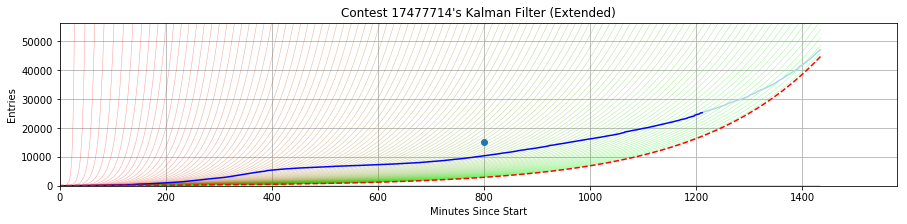

In [819]:
fig = plt.figure(1)
fig.set_size_inches([15, 3])
ax=fig.add_subplot(111)

for i in range(0, len(oldModels)):
    ax.plot(fullSeriesDF['Time'], oldModels[i], label="Log", alpha=.4, color=(1.-i*.009, i*.009, 0.), lw=.5)

ax.plot(cheatDF['Time'], cheatDF['SummedEntries'], label="Actual Result", color="lightblue")
ax.plot(kalmanSeriesDF['Time'], kalmanSeriesDF['SummedEntries'], label="Raw Observations", color="blue")
ax.plot(fullSeriesDF['Time'], y, label="Prediction", color="red", ls = "--")


ax.set_title(title)
ax.set_xlabel("Minutes Since Start")
ax.set_xlim(xmin=0.0, xmax=fullSeriesDF['Time'].max()*1.1)

ax.set_ylabel("Entries")
ax.set_ylim(ymin=0.0, ymax=fullSeriesDF['SummedEntries'].max()*1.2)

ax.plot(800, 15000, marker="o", c="")


ax.grid()



In [100]:
fake = True
######Fake w/ Jon#######
if fake:
    data = pd.DataFrame(data={"Time":[10], "Y":[40]})
    F = np.eye(2) #Transition Matrix (Identity Matrix)
    w = random_state.randn(2, 1)*0 #Noise in the prediction (?) <<<<  FIX THIS
    Z = list(data['Y']) #Observation matrix
    x0 = [[1], [2]] #Inital parameters guess (?) <<<< NEED VALUES
    P0 = [[100, 0], [0, 130]] #Covariance Matrix (The confidence in our prediction)
    R = 1
    fakeResult = goForIt(data, extended=False)
    
    # {'Zs': [22.0],
    #  'Ys': [18.0],
    #  'Hs': [[1.0, array(10)]],
    #  'Ss': [13101.0],
    #  'Ps': [array([[99.23669949, -9.92290665],
    #          [-9.92290665,  1.00221357]])],
    #  'Ks': [array([[0.00763301],
    #          [0.09922907]])],
    #  'Xs': [array([[1.13739409],
    #          [3.7861232 ]])]}
#########################
